In [1]:
import pandas as pd
import numpy as np
import itertools
import tensorflow
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime
import time

In [2]:
img_width, img_height = 224, 224  
   

top_model_weights_path = 'bottleneck_fc_model.h5' 

train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
epochs = 7   
batch_size = 50  

In [3]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)


In [5]:
start = datetime.datetime.now()

datagen = ImageDataGenerator(rescale=1. / 255)  

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict(generator, steps=predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

end = datetime.datetime.now()
elapsed = end - start
print('Time:', elapsed)

Found 9720 images belonging to 5 classes.
195/195 [==============================] - 966s 5s/step
Time: 0:16:09.902845


In [6]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [7]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)
print('-'*117)

Found 1901 images belonging to 5 classes.
39/39 [==============================] - 1051s 28s/step
Time:  0:17:32.706383
---------------------------------------------------------------------------------------------------------------------


In [8]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1268 images belonging to 5 classes.
26/26 [==============================] - 108s 4s/step
Time:  0:01:48.821793


In [9]:
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 9720 images belonging to 5 classes.


In [10]:
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 1901 images belonging to 5 classes.


In [11]:
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1268 images belonging to 5 classes.


In [12]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


Epoch 1/7
195/195 [==============================] - 7s 25ms/step - loss: 0.7377 - acc: 0.7317 - val_loss: 0.2914 - val_acc: 0.9011
Epoch 2/7
195/195 [==============================] - 5s 24ms/step - loss: 0.3932 - acc: 0.8624 - val_loss: 0.2132 - val_acc: 0.9285
Epoch 3/7
195/195 [==============================] - 4s 22ms/step - loss: 0.2842 - acc: 0.9040 - val_loss: 0.2191 - val_acc: 0.9232
Epoch 4/7
195/195 [==============================] - 4s 22ms/step - loss: 0.2352 - acc: 0.9210 - val_loss: 0.2036 - val_acc: 0.9332
Epoch 5/7
195/195 [==============================] - 4s 22ms/step - loss: 0.1975 - acc: 0.9296 - val_loss: 0.1822 - val_acc: 0.9327
Epoch 6/7
195/195 [==============================] - 4s 22ms/step - loss: 0.1768 - acc: 0.9381 - val_loss: 0.1925 - val_acc: 0.9353
Epoch 7/7
39/39 [==============================] - 0s 4ms/step - loss: 0.1810 - acc: 0.9374
[INFO] accuracy: 93.74%
[INFO] Loss: 0.18098731338977814
Time:  0:00:34.275727


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2,514,205
Trainable params: 2,514,205
Non-

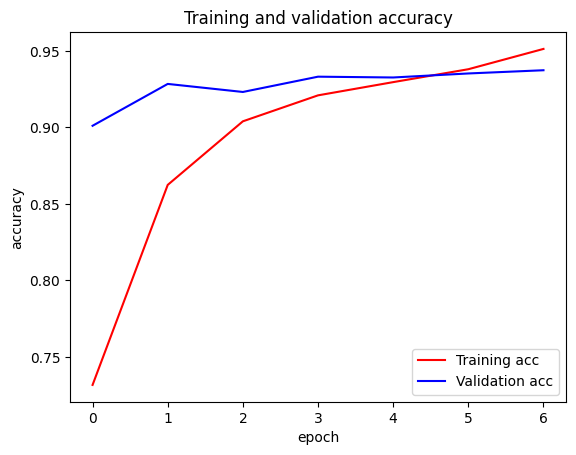

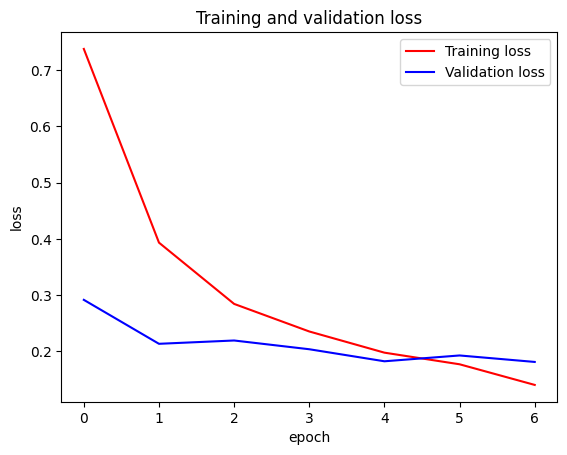

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [15]:
model.evaluate(test_data, test_labels)

40/40 [==============================] - 0s 3ms/step - loss: 9.2582 - acc: 0.1948


[9.25823974609375, 0.19479495286941528]

In [16]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 1.74418509e-01 ... 0.00000000e+00
    6.26517892e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.49968839e-01 0.00000000e+00]
   [6.37098730e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.18942451e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.09405255e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 4.25161809e-01 ... 0.00000000e+00
    3.48450899e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 7.53414035e-01 ... 0.00000000e+00
    7.56485105e-01 0.00000000e+00]]

  [[2.02798545e-01 0.00000000e+00 1.87761188e-01 ... 0.00000000e+00
    9.98507559e-01 0.00000000e+00]
   [2.05920652e-01 0.00000000e+00 2.04942614e-01 ... 0.00000000e+00
    6.94941998e-01 0.00000000e+00]
   [8.11765134e-01 0.00000000e+00 1.79294169e-01 ... 0.00000000e+00
    4.58926380e-01 0.00000000e+00]
   ...
   [5.45519233e-01 0.00000000e+00 1.24649167e+0

40/40 [==============================] - 0s 3ms/step
rounded test_labels [[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [17]:
animals = [ 'cow','elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

         cow       0.04      0.04      0.04       203
   elephants       0.00      0.00      0.00       197
      horses       0.01      0.05      0.02       152
     spiders       0.08      0.01      0.01       472
   squirells       0.74      0.92      0.82       244

   micro avg       0.20      0.19      0.19      1268
   macro avg       0.17      0.20      0.18      1268
weighted avg       0.18      0.19      0.17      1268
 samples avg       0.19      0.19      0.19      1268



C:\Users\Augutsya Pandey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [19]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


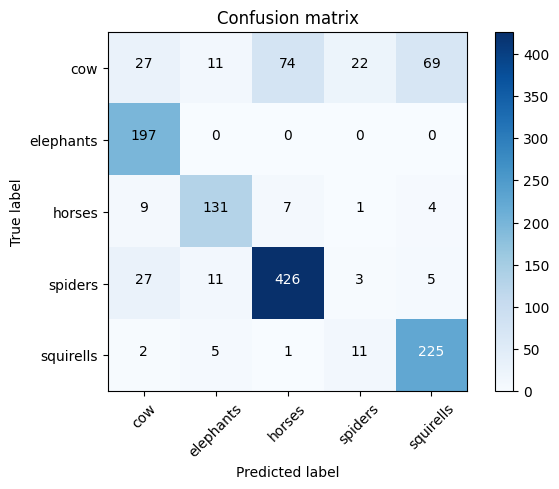

In [20]:
plot_confusion_matrix(confusion_matrix, ['cow', 'elephants', 'horses','spiders', 'squirells'])


Normalized confusion matrix


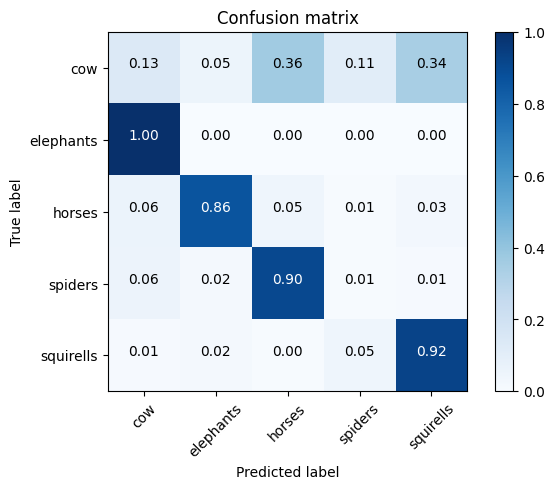

In [21]:
plot_confusion_matrix(confusion_matrix, 
                      ['cow', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

In [22]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 14ms/step
ID: 0, Label: cow 0.0%
ID: 1, Label: elephants 0.0%
ID: 2, Label: horses 100.0%
ID: 3, Label: spiders 0.0%
ID: 4, Label: squirells 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 25ms/step
ID: 3, Label: horses


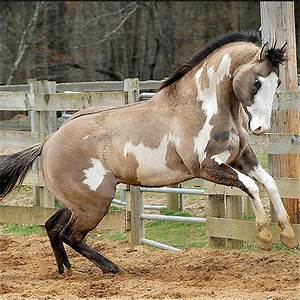

In [31]:
import numpy as np

def test_single_image(path):
    animals = ['cow', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0, 5), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x * 100, 2)))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    class_index = np.argmax(class_predicted[0])  # Get the index of the predicted class
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    class_label = inv_map[class_index+1]  # Get the corresponding label from the dictionary
    print("ID: {}, Label: {}".format(class_index+1, class_label))
    return load_img(path)

path = 'data/test/horses/OIP-U6OsrBIeFdy1_m4eqiGBSAHaHa.jpeg'
test_single_image(path)



[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 18ms/step
ID: 0, Label: cow 0.04%
ID: 1, Label: elephants 99.22%
ID: 2, Label: horses 0.64%
ID: 3, Label: spiders 0.05%
ID: 4, Label: squirells 0.05%
Final Decision:
.
..
...
1/1 [==============================] - 0s 24ms/step
ID: 2, Label: elephants


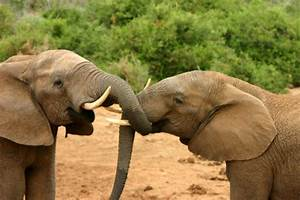

In [32]:

path = 'data/test/elephants/OIP-XM-9quCuvL5sGvykoN-DUwHaE8.jpeg'
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 27ms/step
ID: 0, Label: cow 99.71%
ID: 1, Label: elephants 0.0%
ID: 2, Label: horses 0.28%
ID: 3, Label: spiders 0.0%
ID: 4, Label: squirells 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 28ms/step
ID: 1, Label: cow


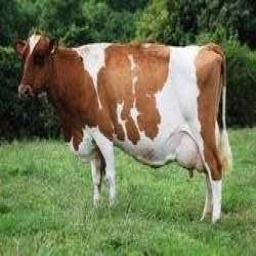

In [43]:


path = 'data/test/cow/SXM9KRWGCSKF.jpg'
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 72ms/step
ID: 0, Label: cow 0.18%
ID: 1, Label: elephants 98.96%
ID: 2, Label: horses 0.52%
ID: 3, Label: spiders 0.22%
ID: 4, Label: squirells 0.12%
Final Decision:
.
..
...
1/1 [==============================] - 0s 29ms/step
ID: 2, Label: elephants


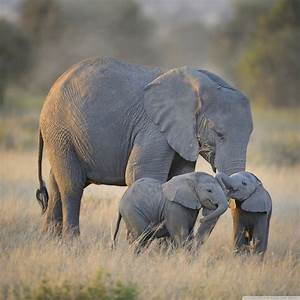

In [38]:


path = 'data/test/elephants/OIP-v9Au4wvcOhj5MSMk421biQHaHa.jpeg'
test_single_image(path)

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 30ms/step
ID: 0, Label: cow 0.0%
ID: 1, Label: elephants 0.0%
ID: 2, Label: horses 99.87%
ID: 3, Label: spiders 0.12%
ID: 4, Label: squirells 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 26ms/step
ID: 3, Label: horses


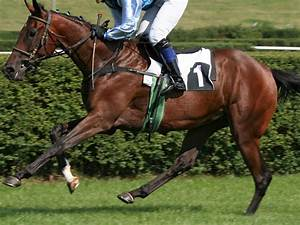

In [42]:
path = 'data/train/horses/OIP-_G7mJhmgMDJ9y_yXm3ArBAHaFj.jpeg'
test_single_image(path)